# In class exercise 10

The purpose of the exercise is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K means, 
DBSCAN,
Hierarchical clustering. 

You can refer to of the codes from  the follwing link below. 
https://www.kaggle.com/karthik3890/text-clustering 
    

In [15]:
# Getting the data

import pandas as pd
data = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\Amazon Unlocked Mobile.csv")
data = data.head(10000)

# Text Cleaning and Preprocessing

data['Clean Reviews'] = data['Reviews'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
data['Clean Reviews'] = data['Clean Reviews'].str.replace('[^\w\s]','')

from nltk.corpus import stopwords
import nltk
stop = stopwords.words('english')
data['Clean Reviews'] = data['Clean Reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

from textblob import Word
data['Clean Reviews'] = data['Clean Reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# TF-IDF vectorizing the data

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(data['Clean Reviews'].values)

----------------------------------------------------------------------
K-MEANS CLUSTERING


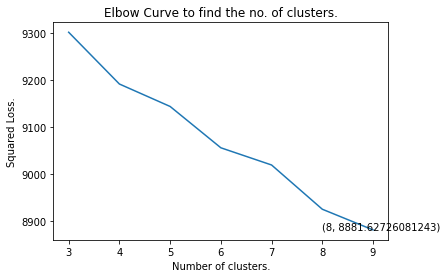

The optimal number of clusters obtained is -  8
The loss for optimal cluster is -  8881.62726081243
The Silhouette Score is:  0.033113456898406286
TF-IDF Cluster Labels
0    6570
1     109
2     360
3     369
4    1023
5    1130
6     188
7     250
Name: Reviews, dtype: int64
Top terms per cluster:
Cluster 0: phone
 good
 great
 iphone
 screen
 one
 use
 nice
Cluster 1: perfect
 condition
 phone
 work
 great
 came
 thank
 every
Cluster 2: good
 phone
 product
 far
 condition
 price
 item
 buy
Cluster 3: great
 work
 phone
 product
 price
 condition
 expected
 fast
Cluster 4: new
 like
 described
 phone
 brand
 iphone
 came
 great
Cluster 5: work
 phone
 great
 fine
 well
 didnt
 good
 doesnt
Cluster 6: excellent
 product
 recommend
 condition
 thanks
 thank
 seller
 phone
Cluster 7: love
 phone
 great
 daughter
 wife
 thanks
 work
 thank


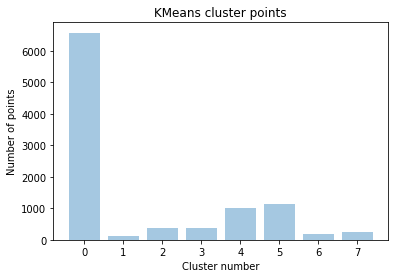

----------------------------------------------------------------------
DBSCAN CLUSTERING


<ipython-input-16-665b7be4f761>:95: RuntimeWarning: invalid value encountered in true_divide
  review_vec /= count_words


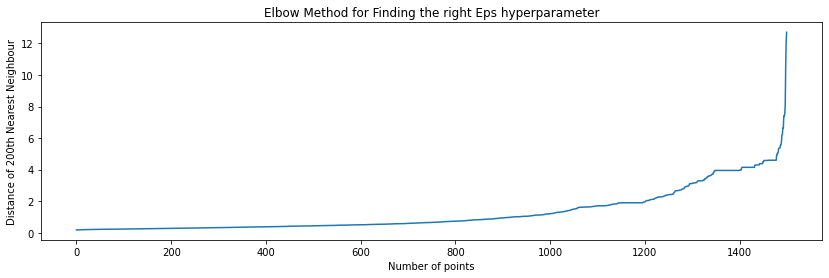

DBSCAN Cluster Labels
0    9999
Name: Reviews, dtype: int64
----------------------------------------------------------------------
HIERARCHICAL CLUSTERING
The Silhouette Score is:  0.14085912521348903


Hierarchical Cluster Labels
0     913
1    3813
2     915
3     339
4    2143
5    1876
Name: Reviews, dtype: int64

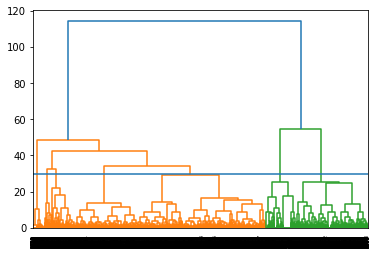

In [16]:
############################################################################################################################
# K-MEANS CLUSTERING

print("-" * 70)
print('K-MEANS CLUSTERING')

# Elbow Method: To get the optimal number of clusters

from sklearn.cluster import KMeans

number_of_clusters = [x for x in range(3, 10)]
squared_errors = []
for cluster in number_of_clusters:
    kmeans = KMeans(n_clusters = cluster).fit(tfidf_vectors)
    squared_errors.append(kmeans.inertia_)

import numpy as np    
optimal_clusters = np.argmin(squared_errors) + 2 

import matplotlib.pyplot as plt
plt.plot(number_of_clusters , squared_errors)
plt.title("Elbow Curve to find the no. of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

# Applying the K-means clustering using optimal K.

optimal_k = 8
model = KMeans(n_clusters = optimal_k).fit(tfidf_vectors)

labels = model.labels_
cluster_centers = model.cluster_centers_
terms = tfidf_vectorizer.get_feature_names()

from sklearn import metrics
silhouette_score = metrics.silhouette_score(tfidf_vectors, labels, metric='euclidean')
print('The Silhouette Score is: ', silhouette_score)

# Assigning each review to a cluster
data['TF-IDF Cluster Labels'] = labels

# Finding the number of reviews in each cluster
print(data.groupby(['TF-IDF Cluster Labels'])['Reviews'].count())

# Finding the top 10 features of each cluster centriod
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
for i in range(optimal_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :optimal_k]:
        print(' %s' % terms[ind], end='')
        print()
        
# Visualizing how reviews are distributed across the clusters 
plt.bar([x for x in range(optimal_k)], data.groupby(['TF-IDF Cluster Labels'])['Reviews'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()     

############################################################################################################################
# DBSCAN CLUSTERING

print("-" * 70)
print('DBSCAN CLUSTERING')

# Finding the optimal number of epsilons

# Creating a text corpus
list_of_reviews=[]
for review in data['Clean Reviews'].values:
    list_of_reviews.append(review.split())
    
# Training the word2vec model using list of reviews
import gensim
w2v_model=gensim.models.Word2Vec(list_of_reviews, size=100, workers=4)

review_vectors = []
for review in list_of_reviews:
    review_vec = np.zeros(100)
    count_words = 0
    for word in review:
        try:
            vec = w2v_model.wv[word]
            review_vec += vec
            count_words += 1
        except:
            pass
    review_vec /= count_words
    review_vectors.append(review_vec)
    
review_vectors = np.array(review_vectors)
review_vectors = np.nan_to_num(review_vectors)

# Computing 200th Nearest neighbour distance
minPts = 2 * 100

def lower_bound(nums, target): # This function returns the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: 
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute_200th_nearest_neighbour(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 )
        if(len(dists) == 200 and dists[199] > dist): 
            l = int(lower_bound(dists, dist))
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199]

# Computing the 200th nearest neighbour distance of some point in the dataset
two_hundreth_neighbour = []
for val in review_vectors[:1500]:
    two_hundreth_neighbour.append(compute_200th_nearest_neighbour(val, review_vectors[:1500]) )
two_hundreth_neighbour.sort()

# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(two_hundreth_neighbour))], two_hundreth_neighbour)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

# Applying the DBSCAN clustering using optimal epsilon.
from sklearn.cluster import DBSCAN
optimal_epsilon = 5
dbscan = DBSCAN(eps = optimal_epsilon, min_samples = 200).fit(review_vectors)

# Assigning each review to a cluster
data['DBSCAN Cluster Labels'] = dbscan.labels_

# Finding the number of reviews in each cluster
print(data.groupby(['DBSCAN Cluster Labels'])['Reviews'].count())

############################################################################################################################
# HIERARCHICAL CLUSTERING

print("-" * 70)
print('HIERARCHICAL CLUSTERING')

# Plotting the Dendogram to find optimal number of clusters
import scipy
from scipy.cluster import hierarchy
dendro = hierarchy.dendrogram(hierarchy.linkage(review_vectors, method='ward'))
plt.axhline(y=30)

# Applying Aggomerative Clustering with 6 clusters
from sklearn.cluster import AgglomerativeClustering
number_of_clusters = 6
agg_model = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
Agg = agg_model.fit_predict(review_vectors)

h_labels = agg_model.labels_

h_silhouette_score = metrics.silhouette_score(review_vectors, h_labels, metric='euclidean')
print('The Silhouette Score is: ', h_silhouette_score)

# Assigning each review to a cluster
data['Hierarchical Cluster Labels'] = h_labels

# Finding the number of reviews in each cluster
data.groupby(['Hierarchical Cluster Labels'])['Reviews'].count()

In one paragraph, please compare K means, DBSCAN and Hierarchical clustering. 

In [ ]:
#You can write you answer here.
'''
The K-means clustering first uses the elbow method to find the optimal number of clusters k. This value occurs when loss 
value is minimum. For our dataset, the optimal number is 8. After applying the clustering algorithm we can see that there 
is an uneven distribution of reviews in the 8 clusters. Cluster 0 has the highest number of reviews i.e. 6570, while the 
least number of reviews is 109, in Cluster 1. There is a huge difference between these two values. Moreover, looking at the 
top 10 terms in each cluster of K-means there is not much difference in terms. The silhouette score is 0.03311 which is not
very high. The value is positive which means the reviews are not in totally opposite clusters but still the clusters are 
not very good.

The DBSCAN clustering also uses the elbow method to find the optimal number of epsilons. The optimal number found using the 
elbow graph is 5. After applying the DBSCAN clustering algorithm we can that it has classified all reviews in only one 
cluster which can mean that all reviews are very similar and fall in one cluster. This can be true because the top 10 terms
in each cluster of K-means were very similar. 

The Hierarchical Clustering plots a dendogram to find the optimal number of clusters. From the dendogram, we deduced that 
6 is the optimal number of clusters. After applying Agglomerative Clustering algorithm we see that there is more even distr-
ibution of reviews in the clusters than K-means clustering. The Silhouette Score for the model is 0.14086 which is much
higher than the score for K-means. The positive value means the reviews are not in totally opposite clusters.

Comparing all three methodologies of clustering, I found DBSCAN to be the best performing. This is because we found the top
10 terms in each cluster of K-means to be so similar that they can be put in one cluster only. And this is what DBSCAN does.
The second best is Hierarchical Clustering because it has a higher silhouette score. K-means using TF-IDF is the worst 
performing for our dataset.
'''